In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # model related data
    plsmodel = None
    # predicted values
    y_pred: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF","ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    
howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "ZORA" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
BH76 No data found for this dataset

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  MCONF
Number of samples:  51
Number of basic descriptors:  51

Reading dataset:  PCONF21
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  SCONF
Number of samples:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    6.410  ,   PBE0  ,   21.488
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   ZORA  ,   14.651
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    1.137  ,   PBE0  ,    5.268
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
       INTRAMOLECULAR_INTERACTIONS_ICONF  ,  2  ,    0.450  ,    PBE  ,    1.496
       INTRAMOLECULAR_INTERACTIONS_IDISP  ,  2  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Kinetic_Energy  
                      PBE0_Kinetic_Energy 0.99
                      ZORA_Kinetic_Energy 0.99
                     TPSSh_Kinetic_Energy 0.99
PBE_Dispersion_correction  
               PBE0_Dispersion_correction 1.00
               ZORA_Dispersion_correction 1.00
              TPSSh_Dispersion_correction 1.00
PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    ZORA_Potential_Energy 0.99
                   TPSSh_Potential_Energy 0.99
PBE_E(X)  
                                PBE0_E(X) 1.00
                                ZORA_E(X) 1.00
                               TPSSh_E(X) 1.00
PBE_FINAL_SINGLE_POINT_ENERGY  
           PBE0_FINAL_SINGLE_POINT_ENERGY 1.00
           ZORA_FINAL_SINGLE_POINT_ENERGY 1.00
          TPSSh_FINAL_SINGLE_POINT_ENERGY 1.00
PBE_Nuclear_Repulsion  
                  PBE_One_Electron_Energy 1.00
                  PBE_Two_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
               

In [6]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   ZORA_One_Electron_Energy
2   TPSSh_One_Electron_Energy
3   TPSSh_E(C)
4   PBE_One_Electron_Energy
5   PBE_Two_Electron_Energy
6   ZORA_FINAL_SINGLE_POINT_ENERGY
7   PBE0_Potential_Energy
8   PBE0_Dispersion_correction
9   PBE0_Two_Electron_Energy
10   TPSSh_E(X)
11   ZORA_Kinetic_Energy
12   TPSSh_Potential_Energy
13   PBE0_One_Electron_Energy
14   TPSSh_Nuclear_Repulsion
15   ZORA_Potential_Energy
16   PBE0_E(X)
17   ZORA_Two_Electron_Energy
18   PBE0_E(C)
19   PBE0_Kinetic_Energy
20   ZORA_E(C)
21   ZORA_E(X)
22   ZORA_Nuclear_Repulsion
23   TPSSh_Dispersion_correction
24   TPSSh_FINAL_SINGLE_POINT_ENERGY
25   PBE0_Nuclear_Repulsion
26   TPSSh_Two_Electron_Energy
27   TPSSh_Kinetic_Energy
28   ZORA_Dispersion_correction
29   PBE0_FINAL_SINGLE_POINT_ENERGY


In [7]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_Kinetic_Energy
2 PBE_FINAL_SINGLE_POINT_ENERGY
3 PBE_Nuclear_Repulsion
4 PBE_E(X)
5 PBE_E(C)
6 PBE_Dispersion_correction
7 PBE_Potential_Energy


In [8]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

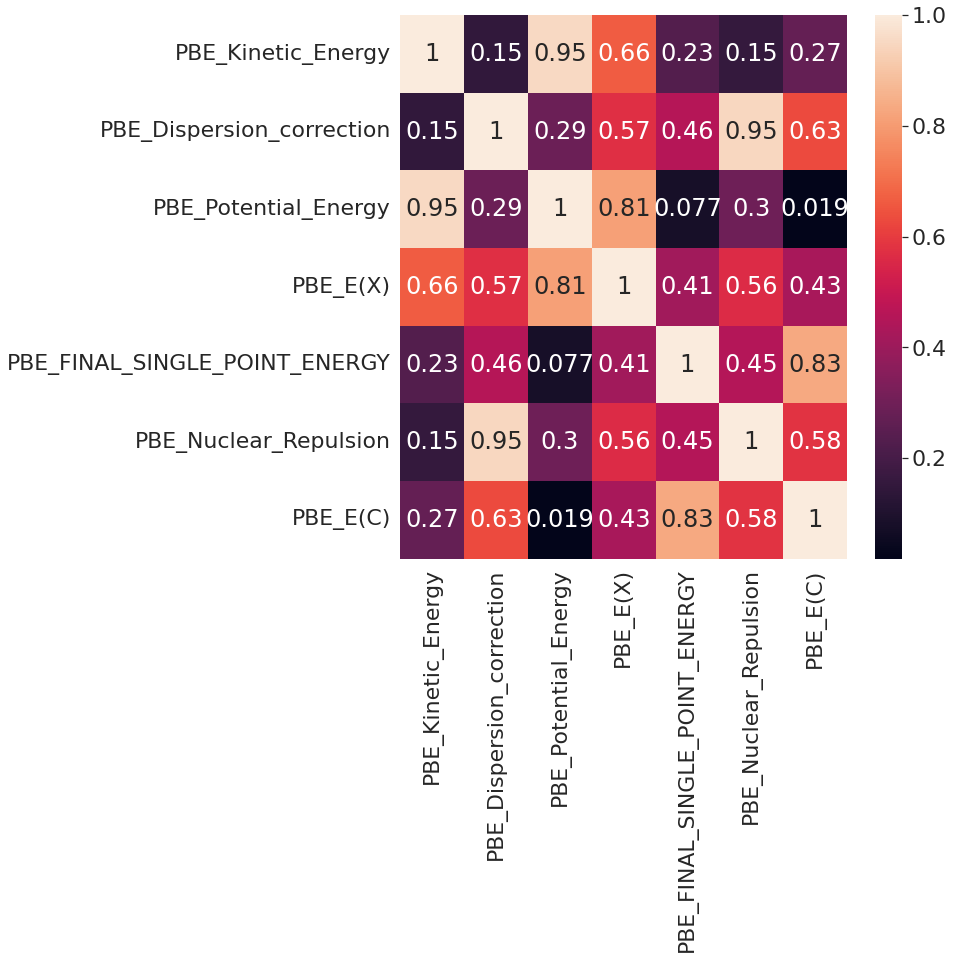

In [9]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [10]:
perc_split = 0.2
for setname in fullsetnames:
       print("Running PLS for dataset: ", setname)

       X, Y, features_names = \
          commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                  models_results[setname].labels)
       maxcomp = X.shape[1]
       ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
              models.pls_model (perc_split, X, Y, \
              ncomp_start = 1, ncomp_max = maxcomp)
       r2max_comps = np.argmax(r2s_test)+1
       rmsemin_comps = np.argmin(rmses_test)+1
       compstouse = min(rmsemin_comps, r2max_comps)
       rmse_train, rmse_test, r2_train, \
          r2_test, rmse_full, r2_full , \
          models_results[setname].plsmodel, \
          X_train, X_test, y_train, y_test  = \
                  models.pls_model (perc_split, X, Y, False, compstouse)
       
       models_results[setname].y_pred = \
          models_results[setname].plsmodel.predict(X) 

Running PLS for dataset:  BARRIER_HEIGHTS
Running PLS for dataset:  BARRIER_HEIGHTS_BHDIV10
Running PLS for dataset:  BARRIER_HEIGHTS_BHPERI
Running PLS for dataset:  BARRIER_HEIGHTS_BHROT27
Running PLS for dataset:  BARRIER_HEIGHTS_INV24
Running PLS for dataset:  BARRIER_HEIGHTS_PX13
Running PLS for dataset:  BARRIER_HEIGHTS_WCPT18
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_ACONF
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_ICONF
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_IDISP
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_MCONF
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_PCONF21
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_SCONF
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS_UPU23
Running PLS for dataset:  SMALL_MOLECULES
Running PLS for dataset:  SMALL_MOLECULES_AL2X6
Running PLS for dataset:  SMALL_MOLECULES_ALK8
Running PLS for dataset:  SMALL_MOLECULES_ALKBDE10
R

In [11]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , R2 , " + \
      "RMSE (superset) , R2 (superset) ," + \
      "RMSE (Full) , R2 (Full) ")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].fulldescriptors, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%r2, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%r2, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%r2)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].fulldescriptors, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)    

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%r2, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%r2, " , ", \
        "%7.3f"%rmse_full, " , ", \
        "%7.3f"%r2_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname
        pls_model = models_results[setname].plsmodel    
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
        y_pred = pls_model.predict(X)
        rmse = mean_squared_error(Y, y_pred, squared=False)
        r2 = r2_score(Y, y_pred)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)
        r2_ssetname = r2_score(Y, y_pred_ssetname)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
        r2_full = r2_score(Y, y_pred_full)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse, " , ", \
            "%7.3f"%r2, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%r2_ssetname, " , ", \
            "%7.3f"%rmse_full, " , ", \
            "%7.3f"%r2_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , R2 , RMSE (superset) , R2 (superset) ,RMSE (Full) , R2 (Full) 
1202 ,                                     Full  ,    9.902  ,   45.954  ,   33.658  ,    0.959  ,   33.658  ,    0.959  ,   33.658  ,    0.959
 118 ,                          BARRIER_HEIGHTS  ,    6.410  ,   21.488  ,    6.966  ,    0.891  ,    6.966  ,    0.891  ,   16.963  ,    0.352
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.651  ,    5.706  ,    0.947  ,   10.043  ,    0.837  ,   16.251  ,    0.574
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    5.587  ,    0.689  ,    5.255  ,    0.725  ,    8.690  ,    0.247
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    1.855  ,    0.866  ,    3.970  ,    0.386  ,    6.680  ,   -0.740
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    3.829  ,    0.972  ,    9.4

In [12]:
# test scaling Y
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].fulldescriptors, \
                                    models_results["Full"].labels)
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))   
Y_s = scalery.transform(Y.reshape(-1, 1))
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X)
  
perc_split = 0.2
maxcomp = X_s.shape[1]

ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
              models.pls_model (perc_split, X_s, Y_s, \
              ncomp_start = 1, ncomp_max = maxcomp)
r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
compstouse = min(rmsemin_comps, r2max_comps)
rmse_train, rmse_test, r2_train, \
    r2_test, rmse_full, r2_full , \
    plsmodel, \
    X_train, X_test, y_train, y_test  = \
        models.pls_model (perc_split, X_s, Y_s, False, compstouse)
       
y_pred_s = plsmodel.predict(X_s)
y_pred = scalery.inverse_transform(y_pred_s)

rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)

print("Scaling Y")
print("RMSE %7.3f"%rmse, " , ", "R2 %7.3f"%r2)  


Scaling Y
RMSE  33.658  ,  R2   0.959


RMSE   6.966  R2   0.891
RMSE (Full)  16.963  R2 (Full)   0.352


<Figure size 720x720 with 0 Axes>

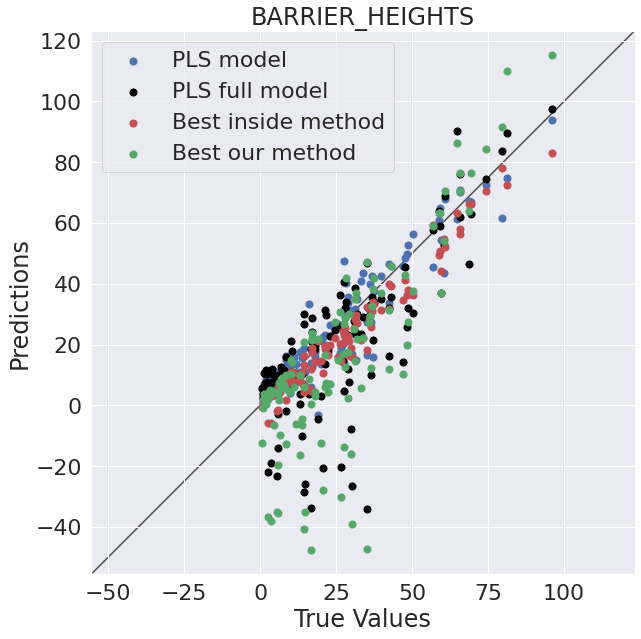

RMSE   5.706  R2   0.947
RMSE (Full)  16.251  R2 (Full)   0.574


<Figure size 720x720 with 0 Axes>

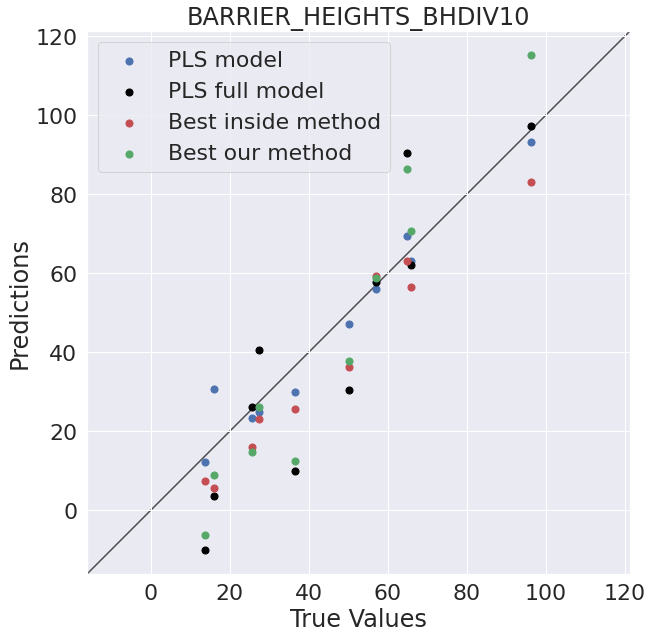

RMSE   5.587  R2   0.689
RMSE (Full)   8.690  R2 (Full)   0.247


<Figure size 720x720 with 0 Axes>

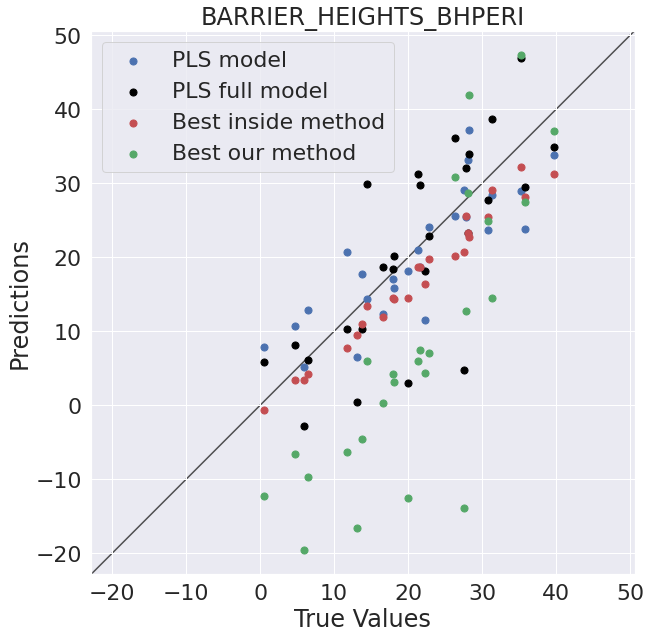

RMSE   1.855  R2   0.866
RMSE (Full)   6.680  R2 (Full)  -0.740


<Figure size 720x720 with 0 Axes>

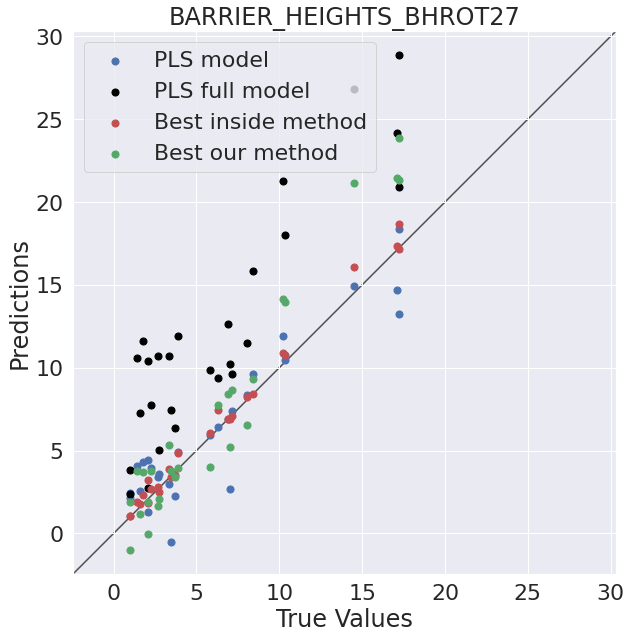

RMSE   3.829  R2   0.972
RMSE (Full)  10.240  R2 (Full)   0.803


<Figure size 720x720 with 0 Axes>

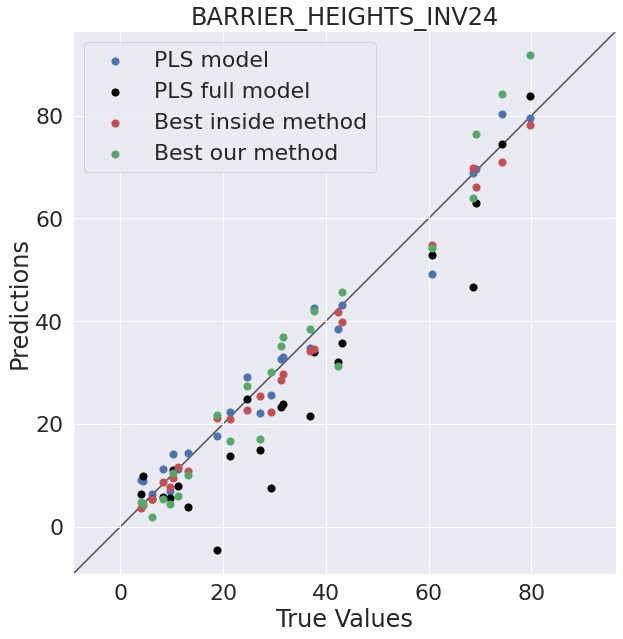

RMSE   1.361  R2   0.991
RMSE (Full)  41.090  R2 (Full)  -7.416


<Figure size 720x720 with 0 Axes>

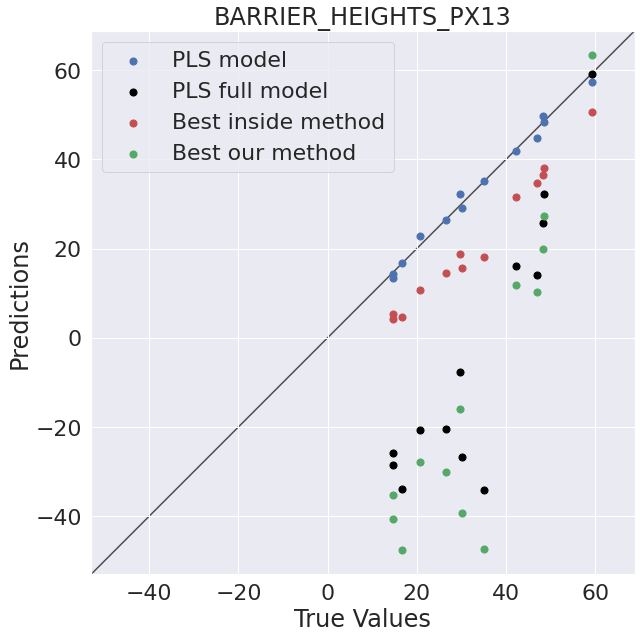

RMSE   3.326  R2   0.979
RMSE (Full)  14.295  R2 (Full)   0.618


<Figure size 720x720 with 0 Axes>

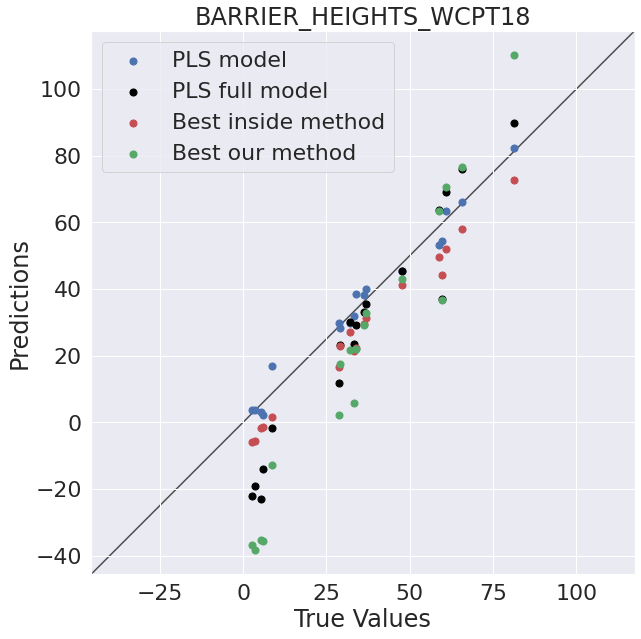

RMSE   2.191  R2   0.869
RMSE (Full)  14.555  R2 (Full)  -4.767


<Figure size 720x720 with 0 Axes>

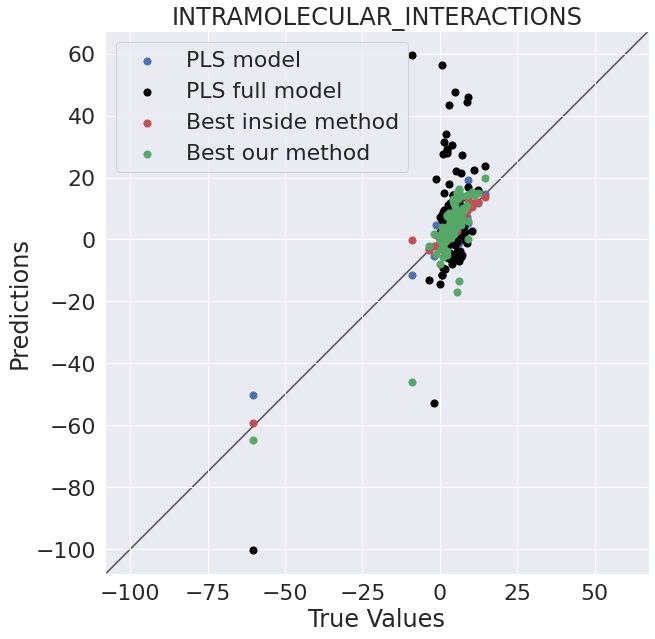

RMSE   0.113  R2   0.992
RMSE (Full)   6.619  R2 (Full) -26.017


<Figure size 720x720 with 0 Axes>

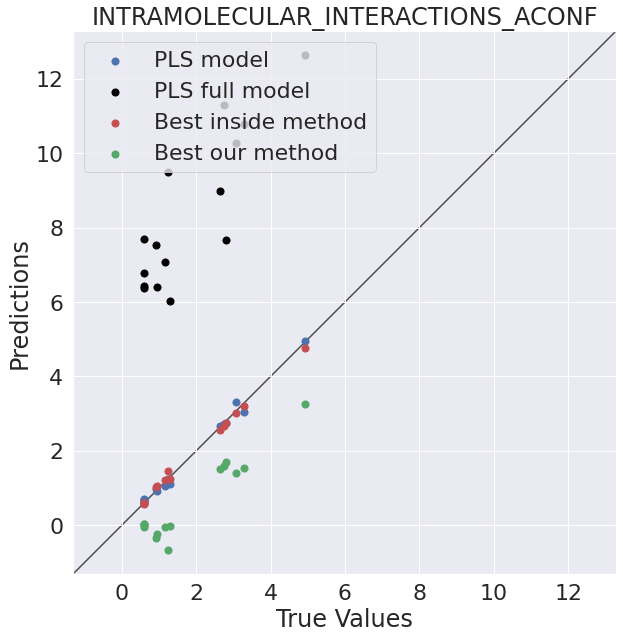

RMSE   0.836  R2   0.930
RMSE (Full)   5.380  R2 (Full)  -1.910


<Figure size 720x720 with 0 Axes>

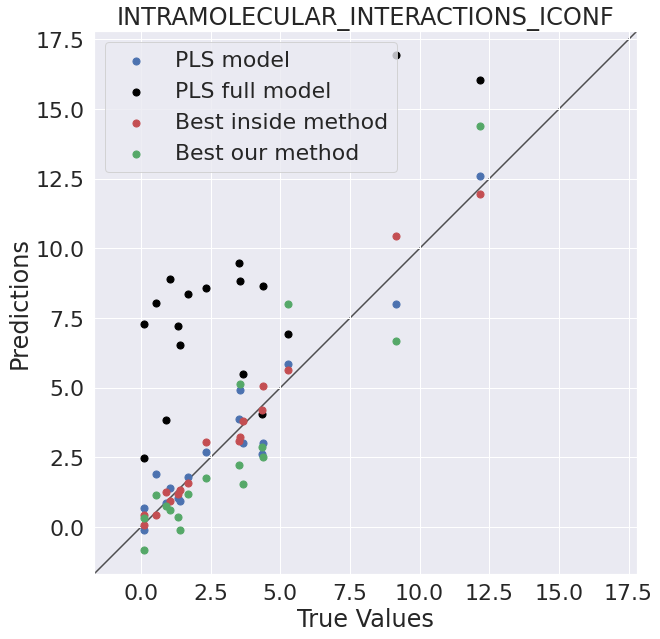

RMSE  19.452  R2   0.260
RMSE (Full)  42.339  R2 (Full)  -2.506


<Figure size 720x720 with 0 Axes>

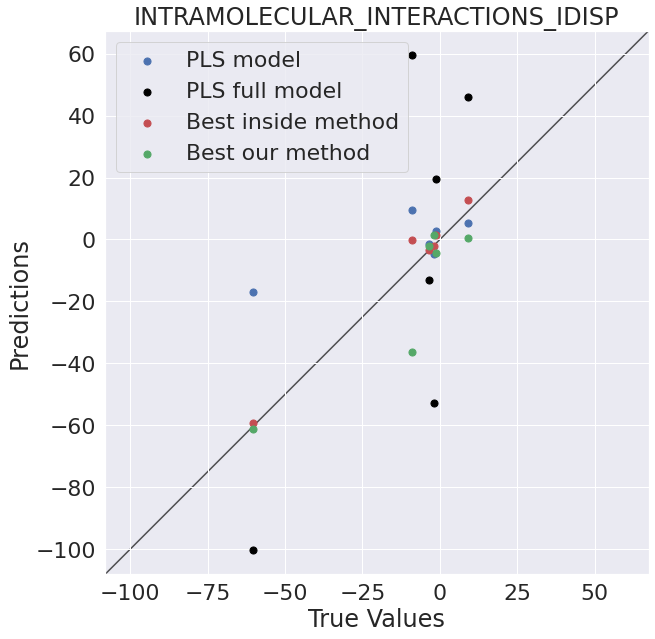

RMSE   0.312  R2   0.975
RMSE (Full)   6.865  R2 (Full) -10.877


<Figure size 720x720 with 0 Axes>

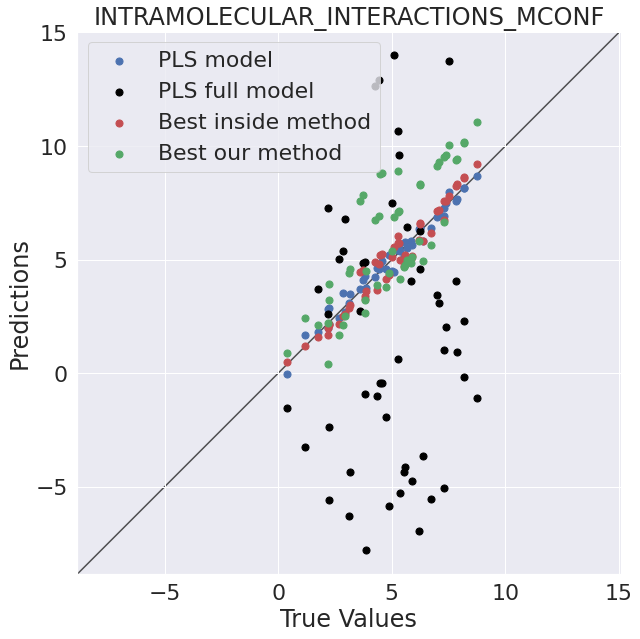

RMSE   0.615  R2   0.336
RMSE (Full)  15.451  R2 (Full) -418.451


<Figure size 720x720 with 0 Axes>

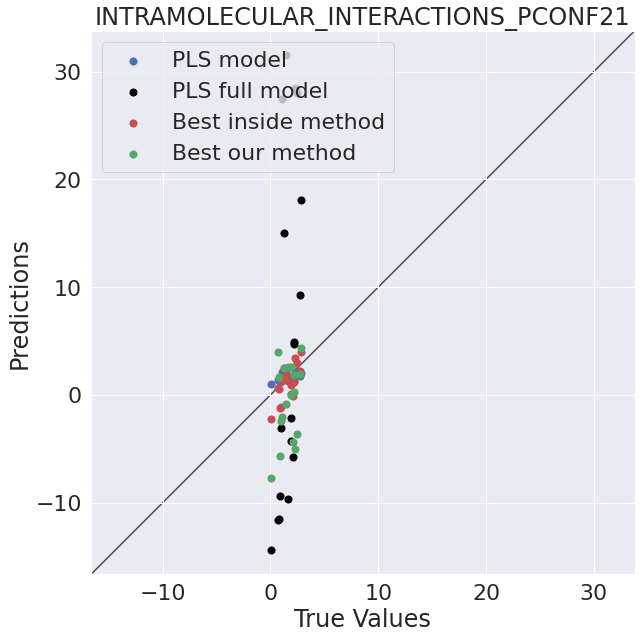

RMSE   0.405  R2   0.953
RMSE (Full)   6.563  R2 (Full) -11.390


<Figure size 720x720 with 0 Axes>

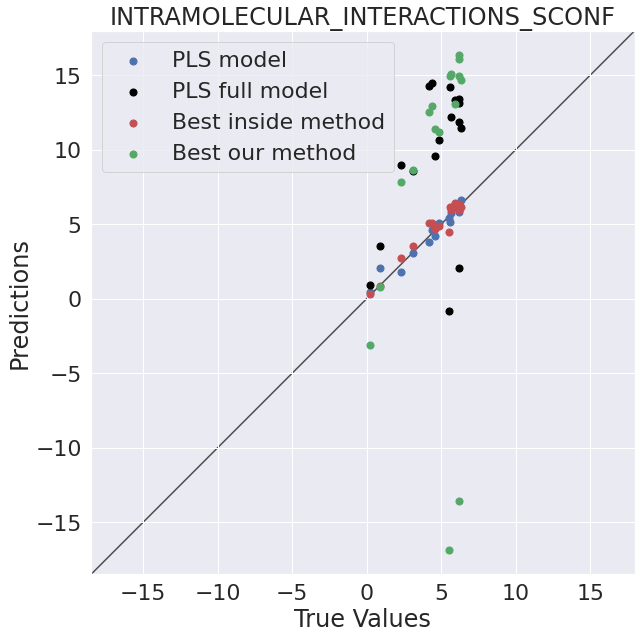

RMSE   0.884  R2   0.919
RMSE (Full)  22.656  R2 (Full) -51.922


<Figure size 720x720 with 0 Axes>

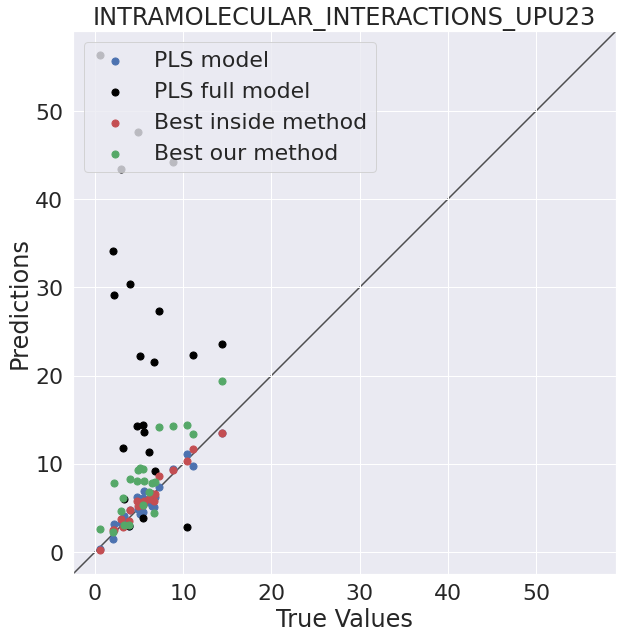

RMSE  28.142  R2   0.980
RMSE (Full)  30.790  R2 (Full)   0.976


<Figure size 720x720 with 0 Axes>

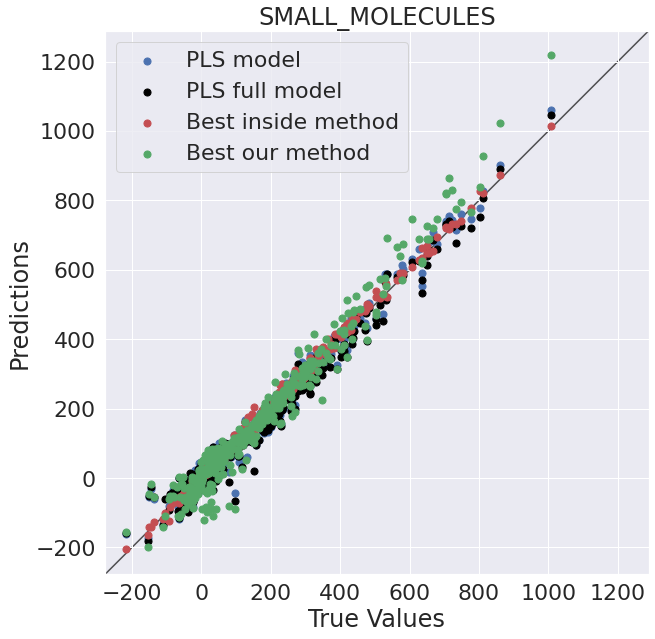

RMSE   1.196  R2   0.981
RMSE (Full)  13.026  R2 (Full)  -1.228


<Figure size 720x720 with 0 Axes>

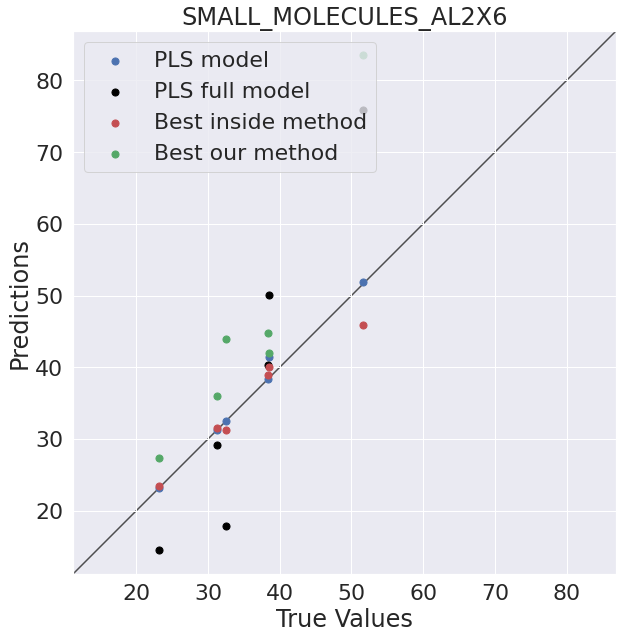

RMSE  10.939  R2   0.878
RMSE (Full)  11.263  R2 (Full)   0.870


<Figure size 720x720 with 0 Axes>

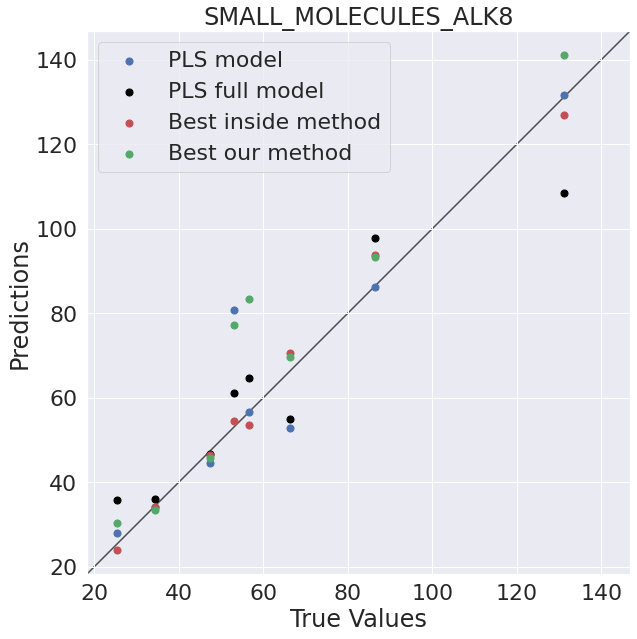

RMSE  24.220  R2   0.413
RMSE (Full)  60.951  R2 (Full)  -2.720


<Figure size 720x720 with 0 Axes>

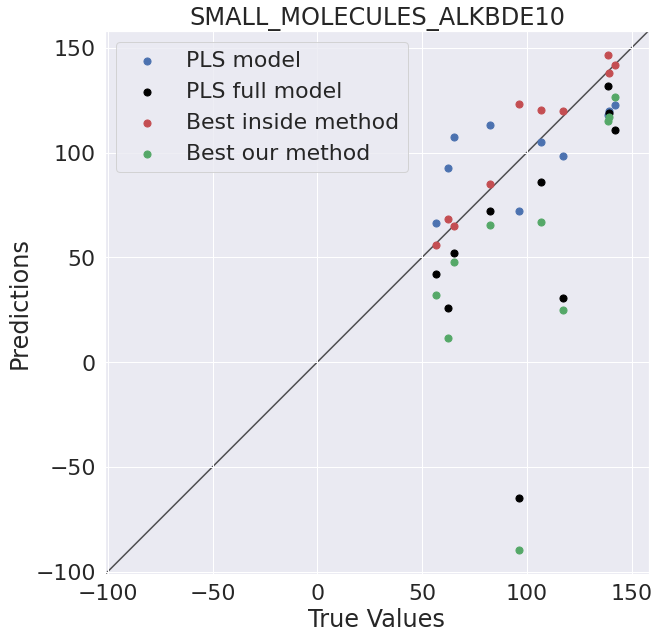

RMSE  19.020  R2   0.926
RMSE (Full)  45.927  R2 (Full)   0.567


<Figure size 720x720 with 0 Axes>

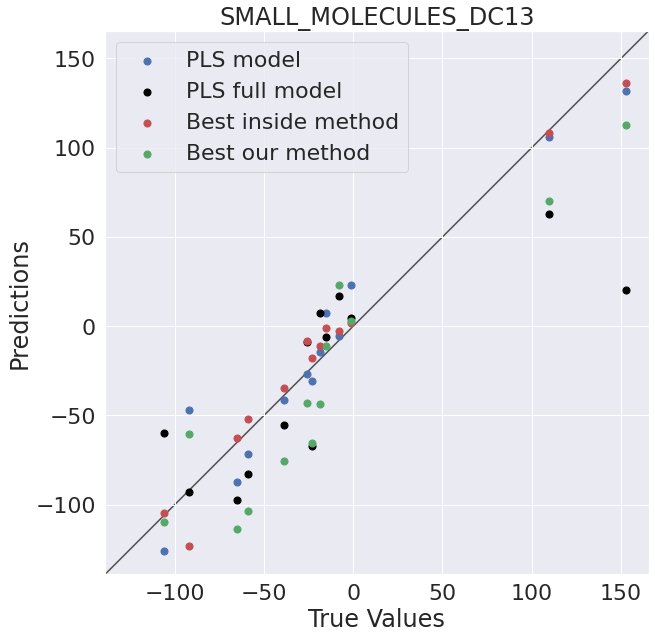

RMSE  33.229  R2   0.828
RMSE (Full)  49.709  R2 (Full)   0.616


<Figure size 720x720 with 0 Axes>

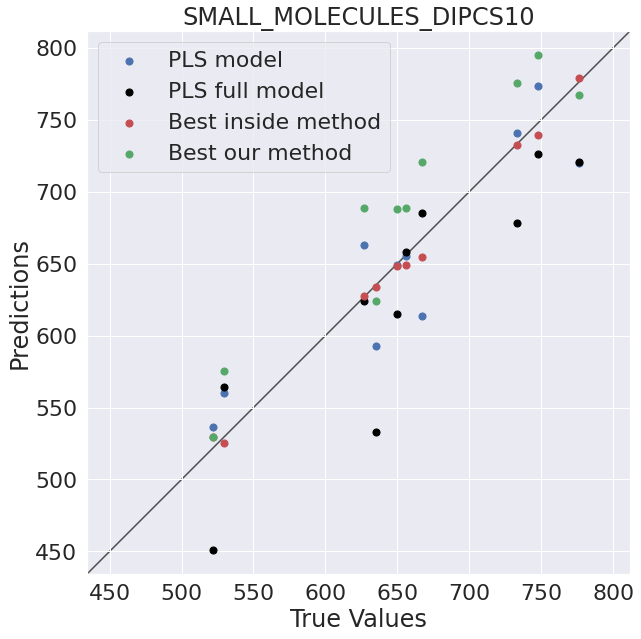

RMSE  17.298  R2   0.727
RMSE (Full)  29.922  R2 (Full)   0.183


<Figure size 720x720 with 0 Axes>

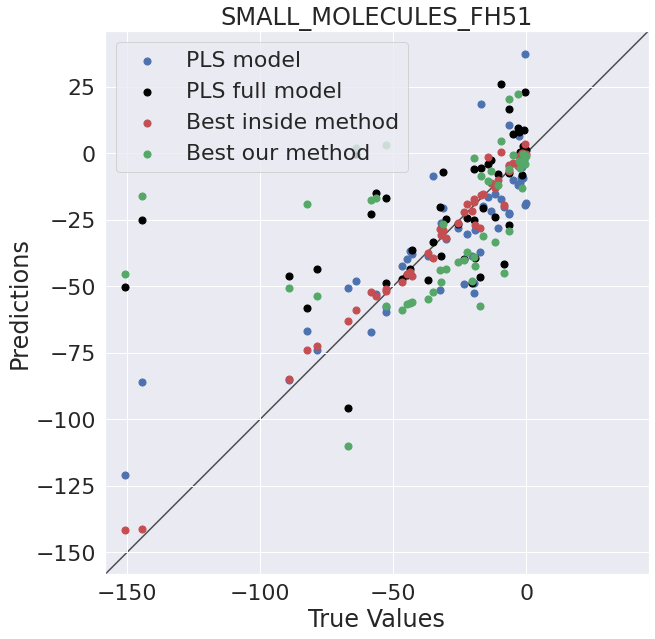

RMSE  18.800  R2   0.346
RMSE (Full)  30.315  R2 (Full)  -0.701


<Figure size 720x720 with 0 Axes>

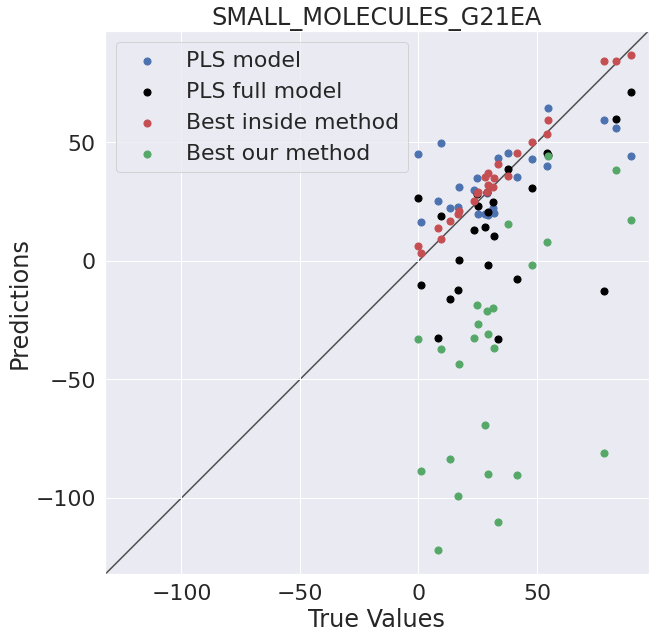

RMSE  22.316  R2   0.877
RMSE (Full)  20.681  R2 (Full)   0.894


<Figure size 720x720 with 0 Axes>

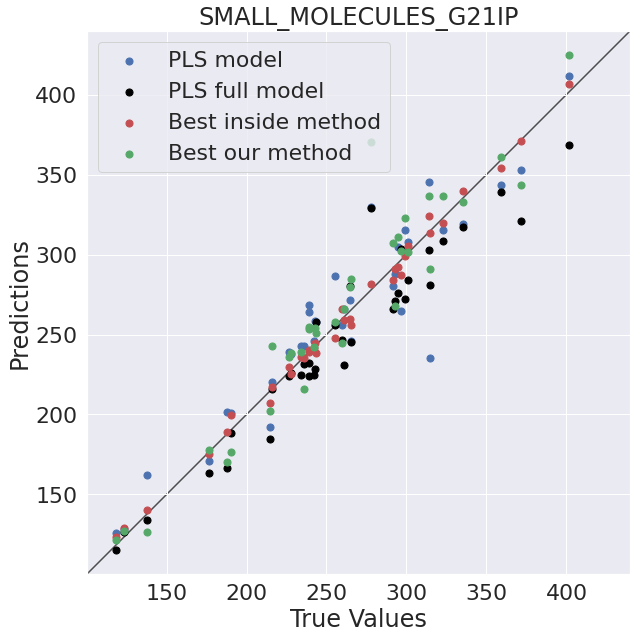

RMSE  25.746  R2   0.754
RMSE (Full)  35.329  R2 (Full)   0.537


<Figure size 720x720 with 0 Axes>

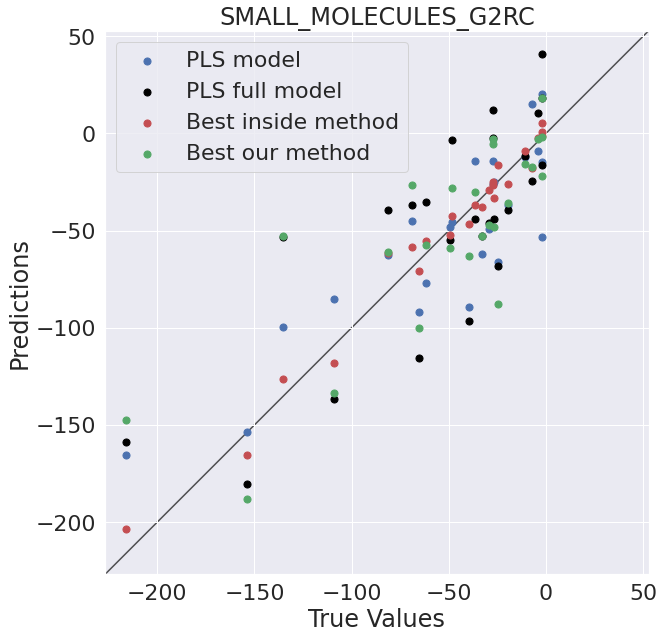

RMSE  11.411  R2   0.852
RMSE (Full)  19.529  R2 (Full)   0.567


<Figure size 720x720 with 0 Axes>

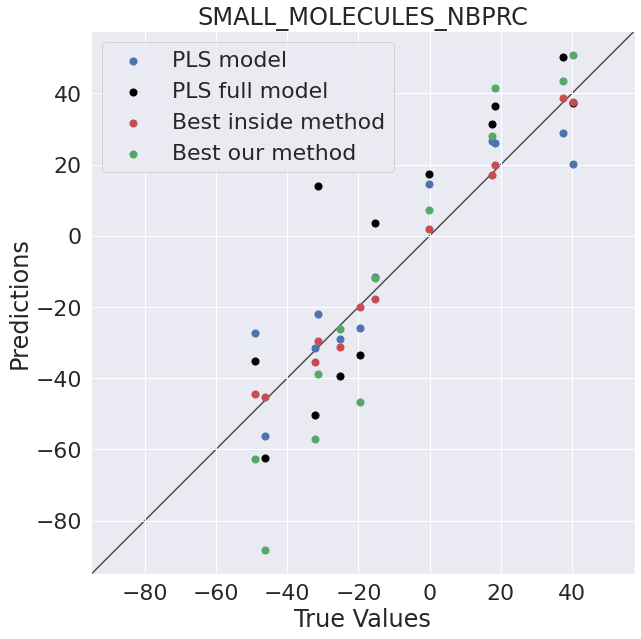

RMSE   5.261  R2   0.974
RMSE (Full)  41.019  R2 (Full)  -0.601


<Figure size 720x720 with 0 Axes>

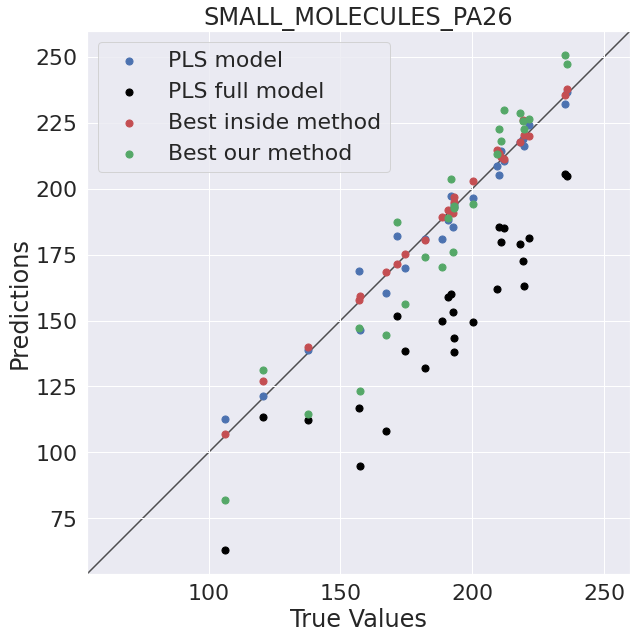

RMSE   9.146  R2   0.882
RMSE (Full)  25.648  R2 (Full)   0.069


<Figure size 720x720 with 0 Axes>

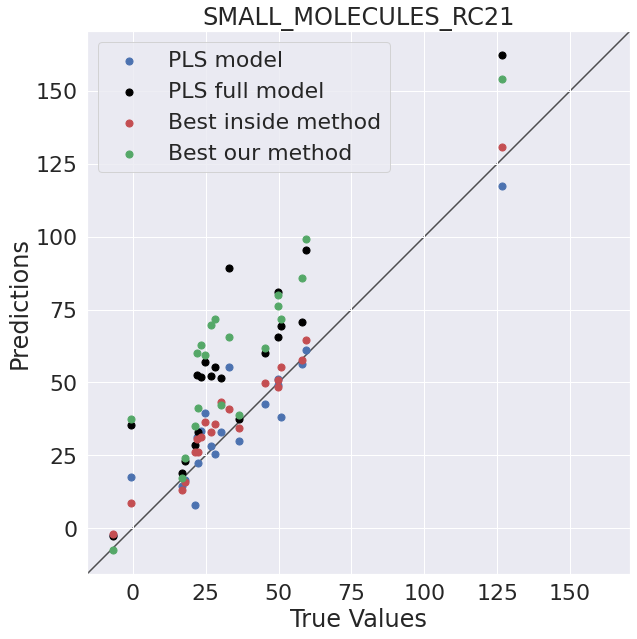

RMSE  11.570  R2   0.571
RMSE (Full)  21.123  R2 (Full)  -0.429


<Figure size 720x720 with 0 Axes>

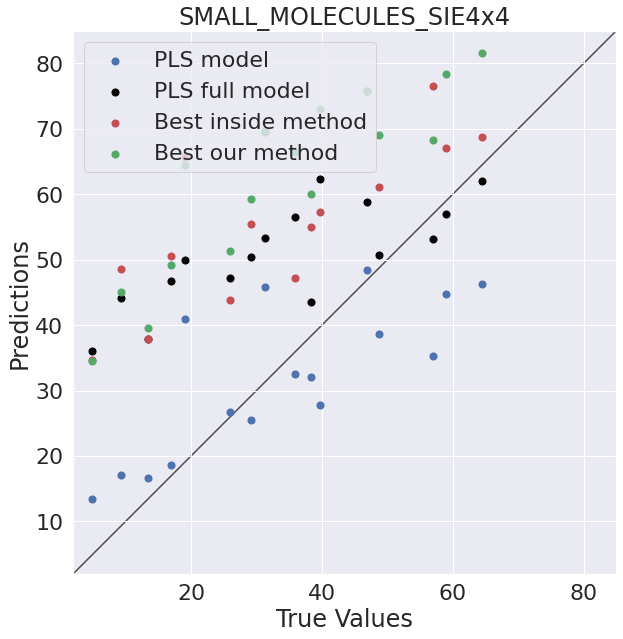

RMSE   2.556  R2   0.591
RMSE (Full)  12.275  R2 (Full)  -8.442


<Figure size 720x720 with 0 Axes>

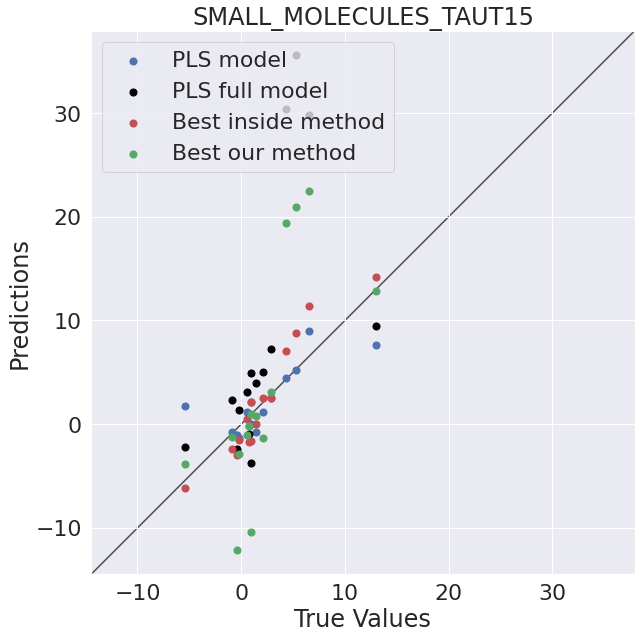

RMSE  16.675  R2   0.992
RMSE (Full)  30.209  R2 (Full)   0.975


<Figure size 720x720 with 0 Axes>

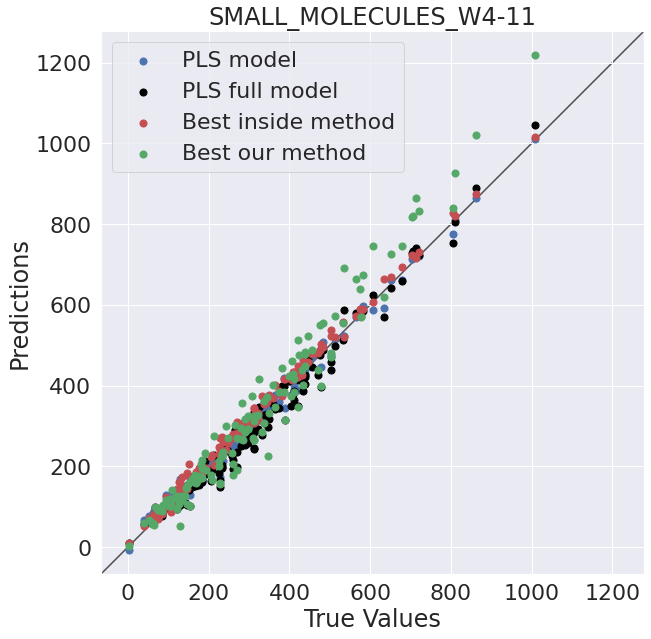

RMSE   4.226  R2   0.955
RMSE (Full)  14.317  R2 (Full)   0.478


<Figure size 720x720 with 0 Axes>

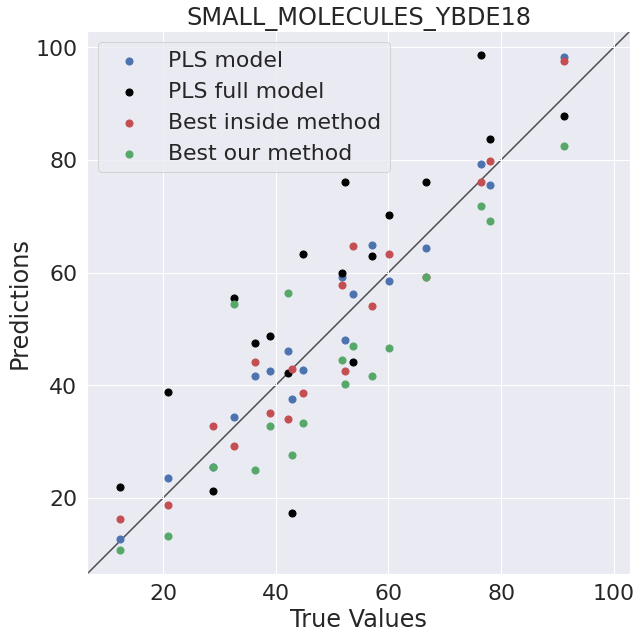

RMSE  11.701  R2   0.923
RMSE (Full)  42.004  R2 (Full)   0.009


<Figure size 720x720 with 0 Axes>

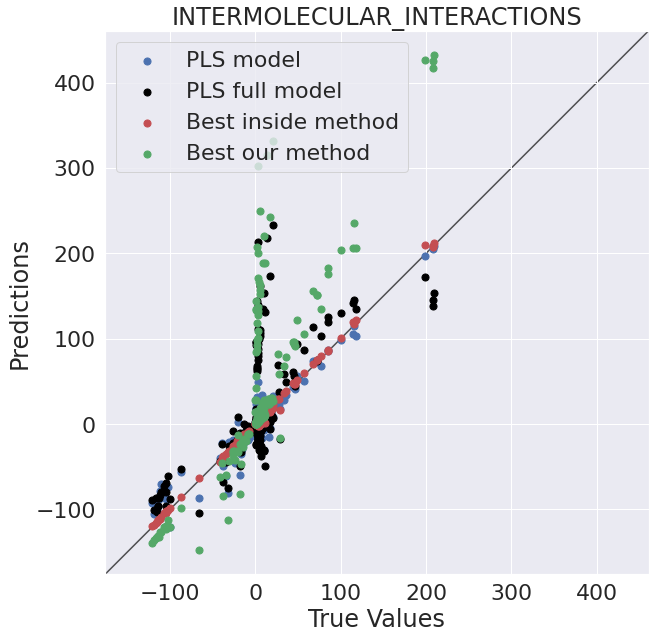

RMSE   0.066  R2   0.998
RMSE (Full)  22.034  R2 (Full) -228.572


<Figure size 720x720 with 0 Axes>

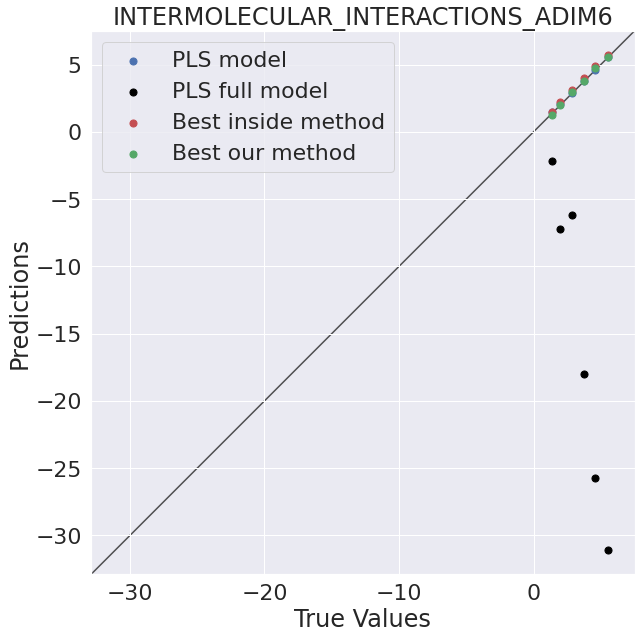

RMSE   1.500  R2   0.987
RMSE (Full)  16.488  R2 (Full)  -0.515


<Figure size 720x720 with 0 Axes>

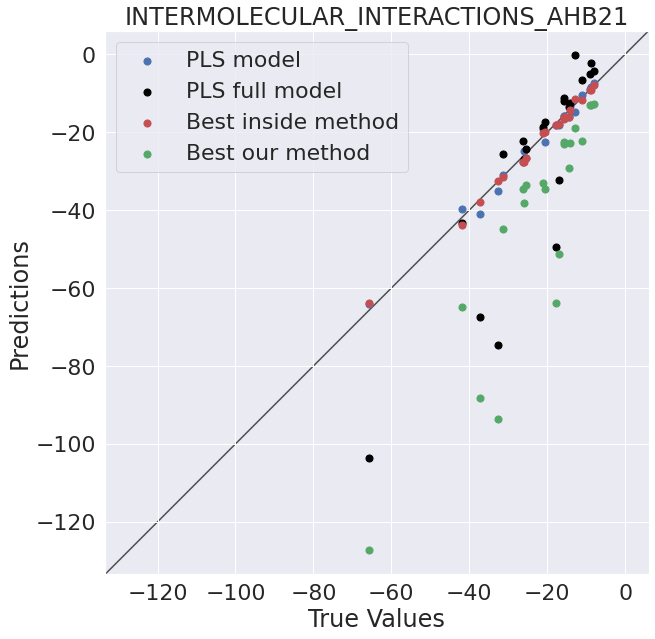

RMSE   0.204  R2   0.998
RMSE (Full)   3.334  R2 (Full)   0.378


<Figure size 720x720 with 0 Axes>

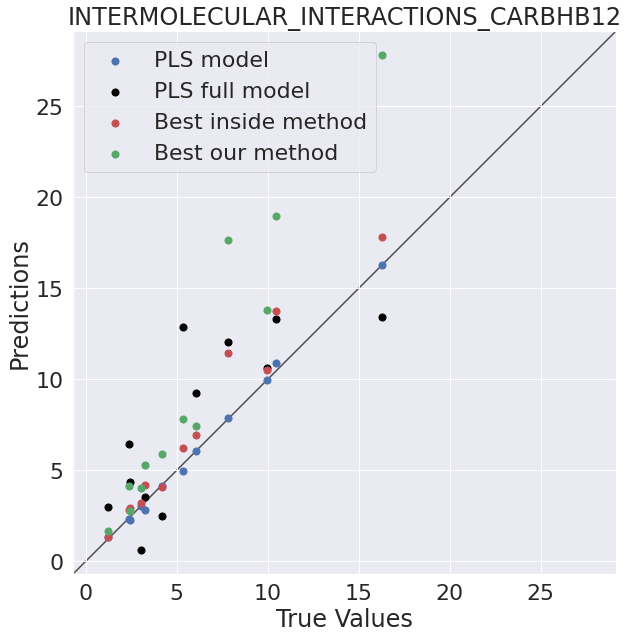

RMSE   4.845  R2   0.595
RMSE (Full)  16.072  R2 (Full)  -3.460


<Figure size 720x720 with 0 Axes>

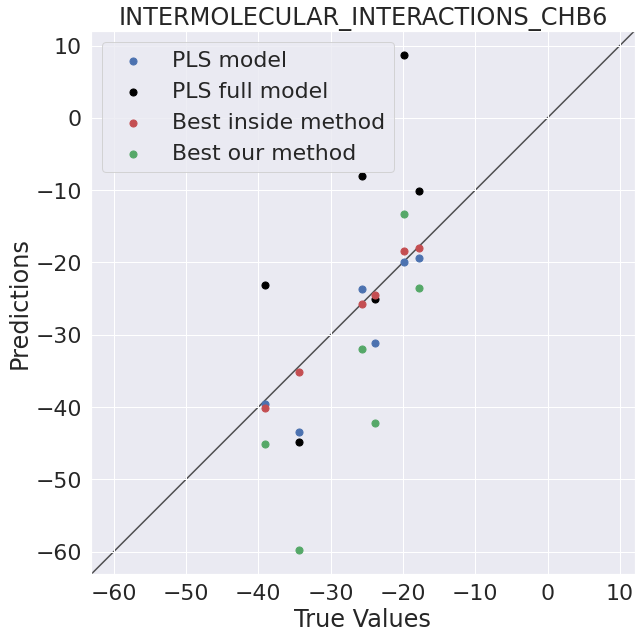

RMSE   2.497  R2   0.649
RMSE (Full)  83.359  R2 (Full) -390.105


<Figure size 720x720 with 0 Axes>

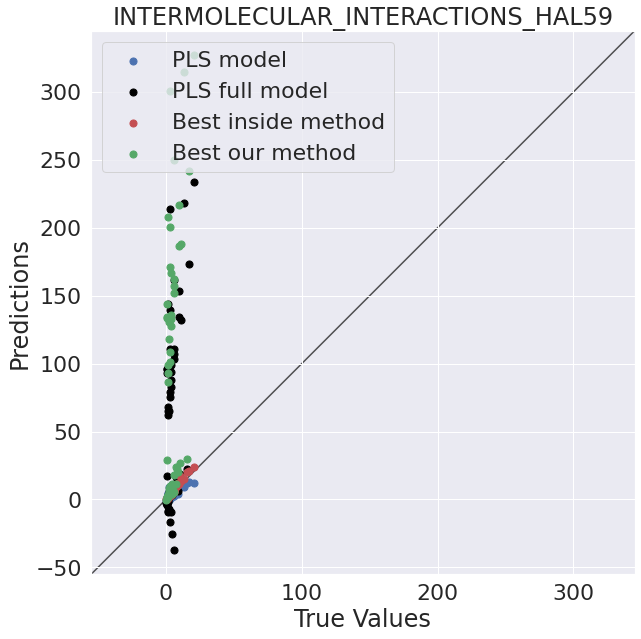

RMSE   2.241  R2   0.923
RMSE (Full)  27.039  R2 (Full) -10.244


<Figure size 720x720 with 0 Axes>

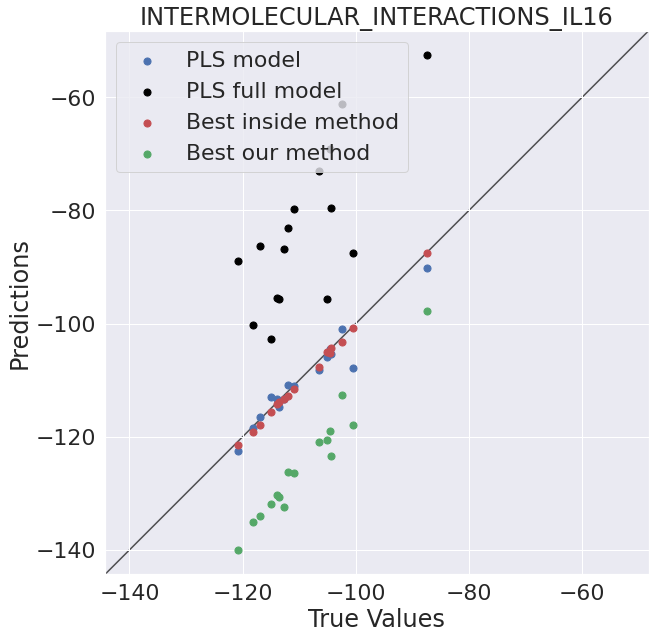

RMSE   0.480  R2   0.967
RMSE (Full)   6.478  R2 (Full)  -5.038


<Figure size 720x720 with 0 Axes>

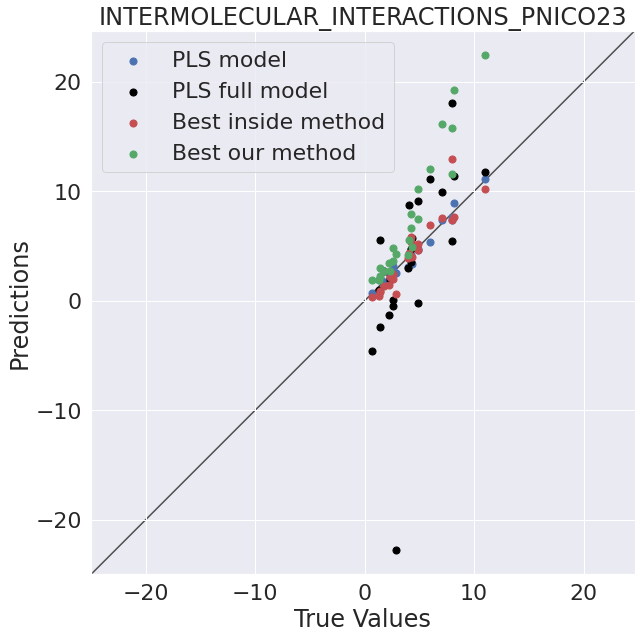

RMSE   0.069  R2   0.970
RMSE (Full)   9.535  R2 (Full) -563.905


<Figure size 720x720 with 0 Axes>

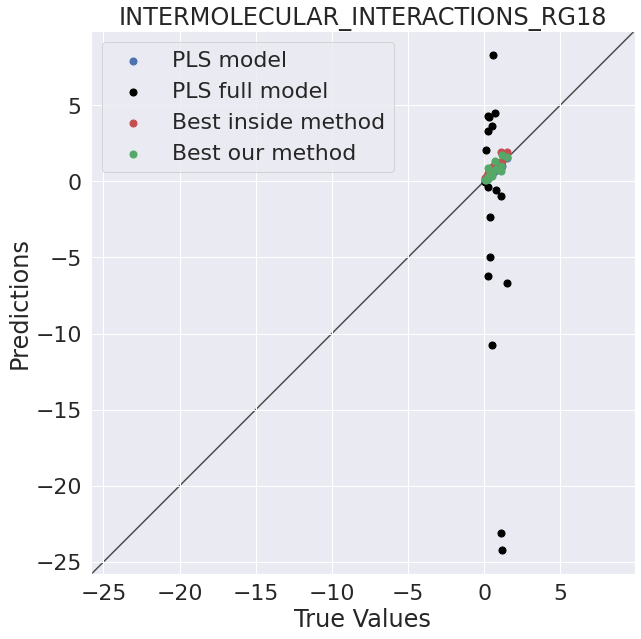

RMSE   0.656  R2   0.989
RMSE (Full)  21.220  R2 (Full) -10.337


<Figure size 720x720 with 0 Axes>

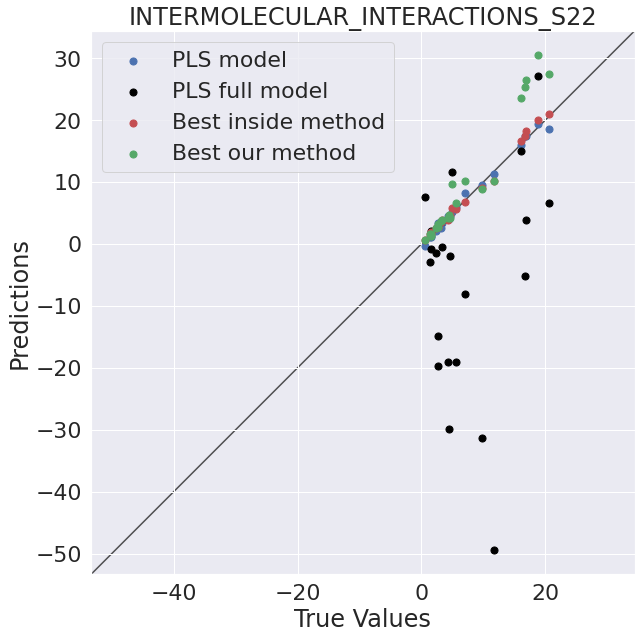

RMSE   0.480  R2   0.986
RMSE (Full)  14.140  R2 (Full) -10.849


<Figure size 720x720 with 0 Axes>

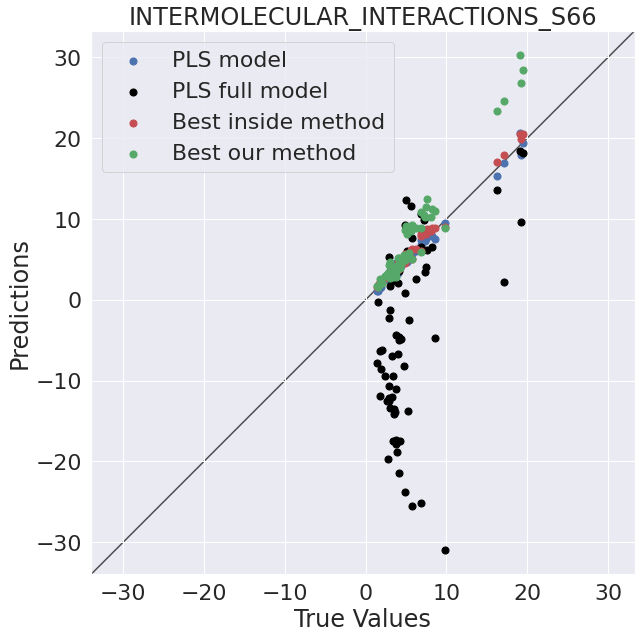

RMSE   2.650  R2   0.998
RMSE (Full)  32.928  R2 (Full)   0.697


<Figure size 720x720 with 0 Axes>

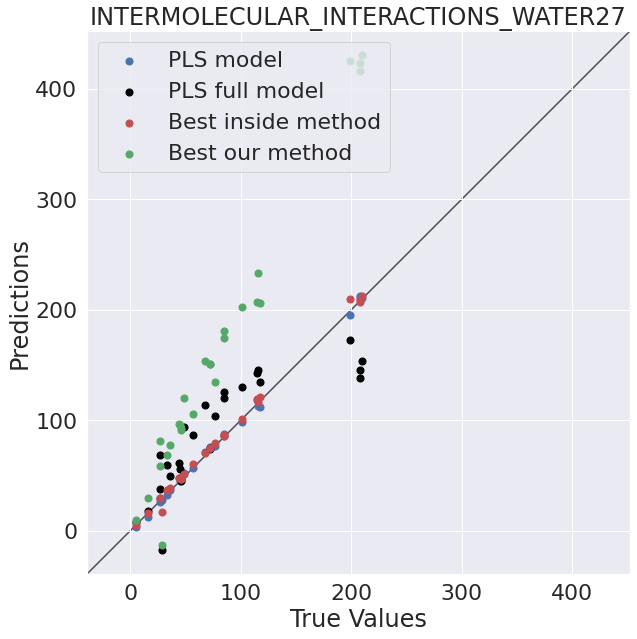

RMSE  31.652  R2   0.978
RMSE (Full)  41.800  R2 (Full)   0.962


<Figure size 720x720 with 0 Axes>

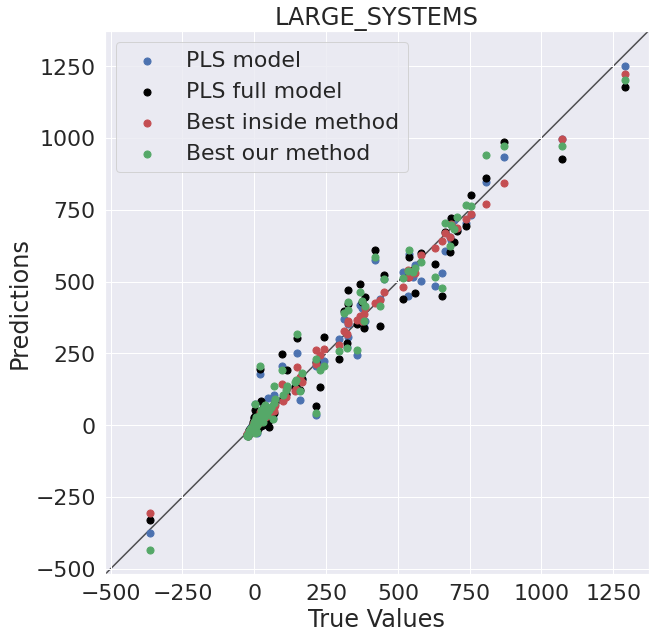

RMSE   0.501  R2   0.998
RMSE (Full)  17.572  R2 (Full)  -1.664


<Figure size 720x720 with 0 Axes>

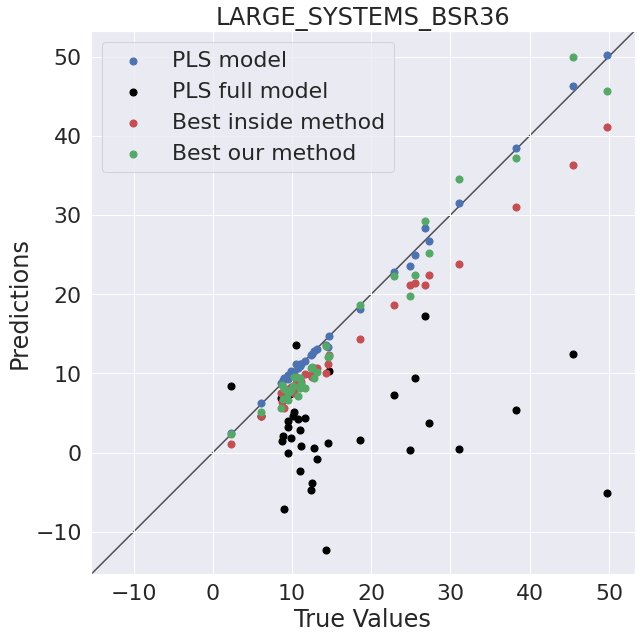

RMSE   2.075  R2   0.998
RMSE (Full)   5.379  R2 (Full)   0.984


<Figure size 720x720 with 0 Axes>

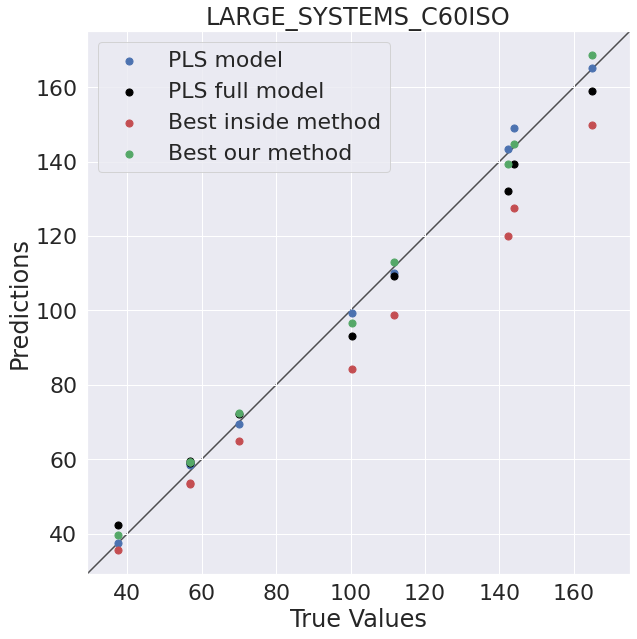

RMSE   0.304  R2   0.993
RMSE (Full)   8.725  R2 (Full)  -4.658


<Figure size 720x720 with 0 Axes>

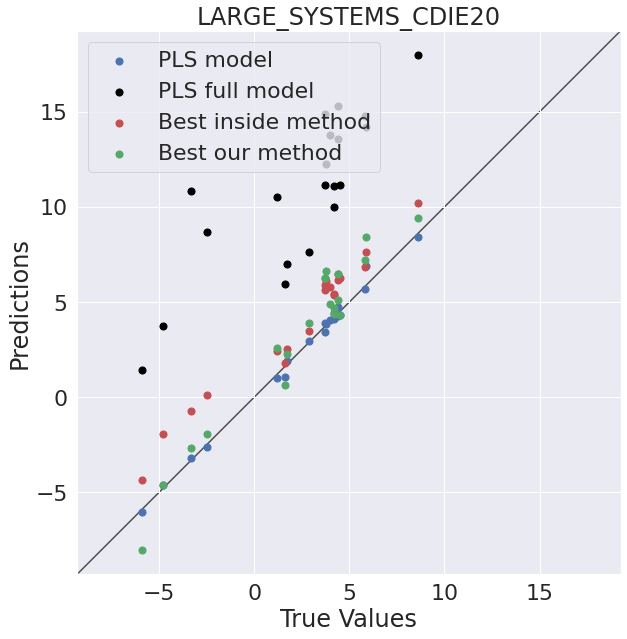

RMSE   5.737  R2   0.835
RMSE (Full)  11.385  R2 (Full)   0.351


<Figure size 720x720 with 0 Axes>

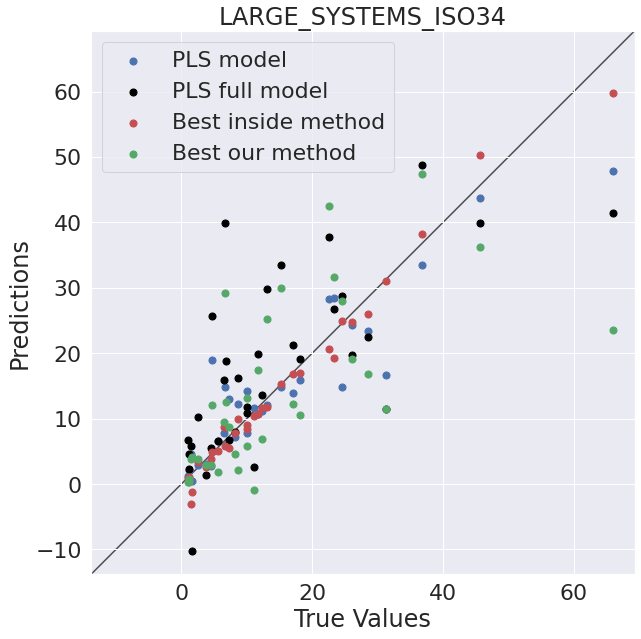

RMSE   9.815  R2   0.707
RMSE (Full)  21.779  R2 (Full)  -0.442


<Figure size 720x720 with 0 Axes>

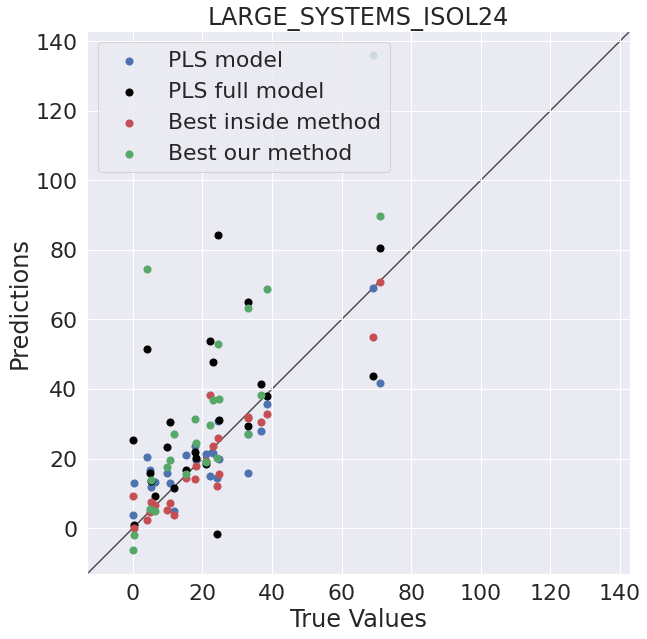

RMSE  68.461  R2   0.946
RMSE (Full)  92.384  R2 (Full)   0.902


<Figure size 720x720 with 0 Axes>

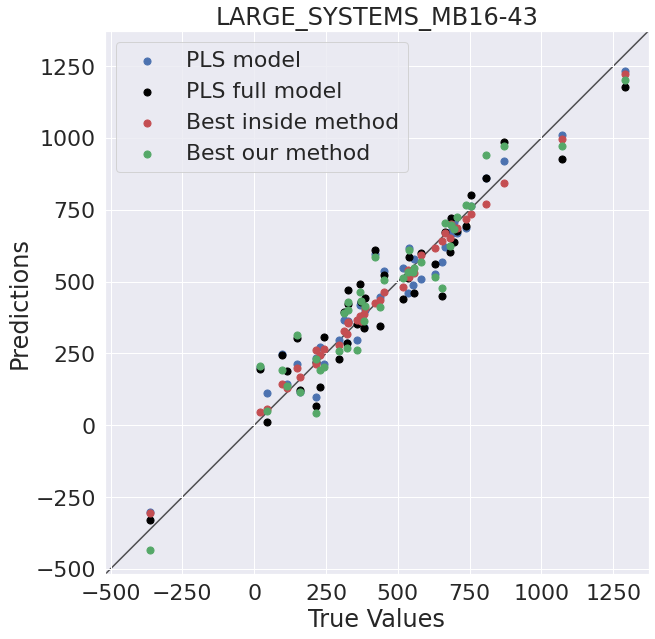

RMSE   2.510  R2   0.639
RMSE (Full)  12.919  R2 (Full)  -8.575


<Figure size 720x720 with 0 Axes>

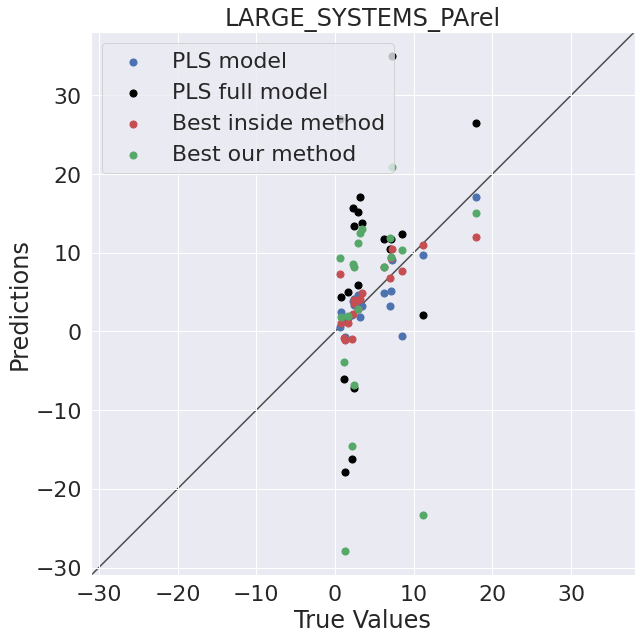

RMSE   2.537  R2   0.880
RMSE (Full)   5.021  R2 (Full)   0.528


<Figure size 720x720 with 0 Axes>

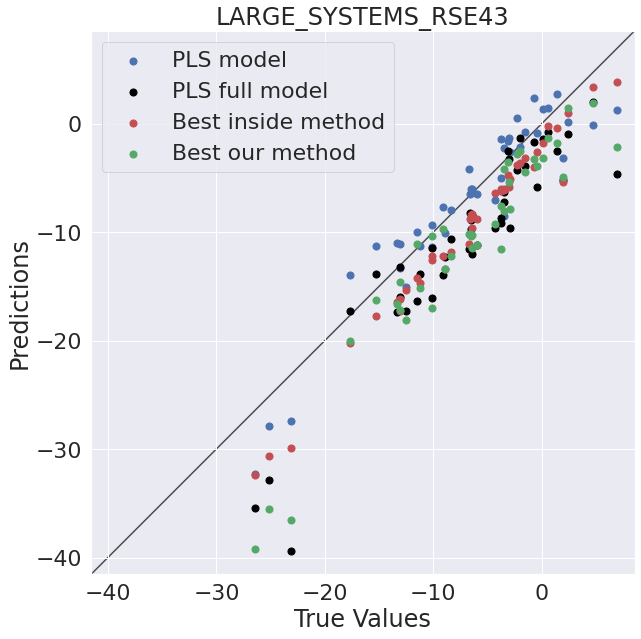

RMSE  33.658  R2   0.959
RMSE (Full)  33.658  R2 (Full)   0.959


<Figure size 720x720 with 0 Axes>

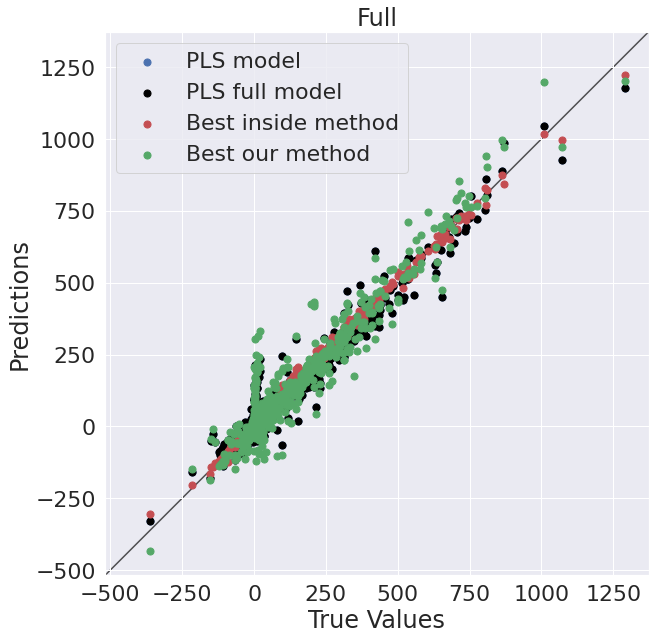

In [13]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:

    pls_model = models_results[setname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)

    y_pred = pls_model.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)

    print("RMSE %7.3f"%rmse, " R2 %7.3f"%r2)
    print("RMSE (Full) %7.3f"%rmse_full, " R2 (Full) %7.3f"%r2_full)
    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='PLS model')
    ax.scatter(Y, y_pred_full, c='black', s=50, label='PLS full model')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()
